In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
import sys
import time
import sqlite3
from scipy.stats import rankdata
from scipy.stats import stats
from scipy.optimize import minimize

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


원래의 DAA 전략에 미국 섹터를 섞어 미국 주식 / 선진국 주식 / 신흥국 주식 / 미국 섹터 / 미국 국채 / 미국 회사채 / 미국 잡채권 / 부동산 / 원자재 / 금으로 테스트해 봅니다. 

전략은 미국 주식 / 선진국 주식 / 신흥국 주식 / 미국 섹터 / 미국 잡채권 / 부동산 / 원자재 / 금을 공격 자산으로 잡고, 방어 자산으로 국채 / 회사채를 잡습니다. 공격 자산에 상대 모멘텀을 적용하여 8가지 중 가장 성과가 좋은 4가지를 삽니다. 성과 판정의 기준은 최근의 정보에 더 높은 가중치를 부여하여 12 x 1개월 수익 + 4 x 3개월 수익 + 2 x 6개월 수익 + 1 x 12개월 수익을 기준으로 합니다. 4가지 자산군을 결정했으면 그 자산군 안에서 다시 같은 방식으로 모멘텀 판정을 하여 4개 자산군마다 1가지씩 선택합니다. 미국 잡채권(AGG), 신흥국 주식(VWO) 두 가지를 카나리아로 하여 두 가지 다 수익이 +면 공격 자산 100% 보유하고, 1가지 +면 공격 자산 50% 보유, 둘 다 -면 공격 자산은 보유하지 않습니다. 방어 자산은 공격 자산을 사지 않은 만큼을 채워넣는데, 방어의 목적이므로 미국 단기 국채, 미국 중기 국채, 미국 회사채에 한정합니다. 방어 자산 중 가장 최근 성과가 좋은 자산을 삽니다. 리밸런싱은 월별로 진행합니다. 

각 자산군별로 적당한 선택지입니다. 

<ETF 목록>
    - 미국 주식: VTI (Vanguard US Total Stock)
    - 선진국 주식: EFA (iShares MSCI EAFE)
    - 신흥국 주식: VWO (Vanguard Emerging)
    - 미국 섹터: XLB (SPDR Materials), XLE (SPDR Energy), XLF (SPDR FInance), XLI (SPDR Industrial), XLK (SPDR Technology), 
                 XLP (SPDR Consumer Staples), XLU (SPDR Utilities), XLV (SPDR Healthcare), XLY (SPDR Consumer Discretionary)
    - 미국 국채: SHY (iShares 1-3 years Treasury), IEF (iShares 7-10 years Treasury)
    - 미국 회사채: LQD (iShares Investment Grade Corporate Bond)
    - 미국 잡채권: AGG (iShares US Aggregate Bond)
    - 부동산: VNQ (Vanguard Real Estate)
    - 원자재: DBC (Invesco DB Commodity)
    - 금: IAU (iShares Gold)
    
데이터가 모두 존재해야 하므로, 2006년 3월부터로 진행합니다.

In [2]:
start = '2006-03-02'
end = '2021-02-26'

USEquity = ['VTI']
DevelopedEquity = ['EFA']
EmergingEquity = ['VWO']
USSector = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']
USTreasury = ['SHY','IEF']
USCorporateBond = ['LQD']
USAggBond = ['AGG']
REITs = ['VNQ']
Commodity = ['DBC']
Gold = ['IAU']
Canary = ['AGG','VWO']

Total = USEquity + DevelopedEquity + EmergingEquity + USSector + USTreasury + USCorporateBond + USAggBond + REITs + Commodity + Gold
    
Defense = USTreasury + USCorporateBond

In [3]:
vti = web.DataReader('VTI','yahoo',start,end)
efa = web.DataReader('EFA','yahoo',start,end)
vwo = web.DataReader('VWO','yahoo',start,end)
xlb = web.DataReader('XLB','yahoo',start,end)
xle = web.DataReader('XLE','yahoo',start,end)
xlf = web.DataReader('XLF','yahoo',start,end)
xli = web.DataReader('XLI','yahoo',start,end)
xlk = web.DataReader('XLK','yahoo',start,end)
xlp = web.DataReader('XLP','yahoo',start,end)
xlu = web.DataReader('XLU','yahoo',start,end)
xlv = web.DataReader('XLV','yahoo',start,end)
xly = web.DataReader('XLY','yahoo',start,end)
shy = web.DataReader('SHY','yahoo',start,end)
ief = web.DataReader('IEF','yahoo',start,end)
lqd = web.DataReader('LQD','yahoo',start,end)
agg = web.DataReader('AGG','yahoo',start,end)
vnq = web.DataReader('VNQ','yahoo',start,end)
dbc = web.DataReader('DBC','yahoo',start,end)
iau = web.DataReader('IAU','yahoo',start,end)

In [4]:
price_data = [vti,efa,vwo,xlb,xle,xlf,xli,xlk,xlp,xlu,xlv,xly,shy,ief,lqd,agg,vnq,dbc,iau]

In [5]:
MomentumScore = pd.DataFrame(index = vti.index)

for i in range(len(price_data)):
    
    temp = []
    asset = price_data[i]
    
    for j in range(len(asset)):
        Momentum = asset['Adj Close'].pct_change(periods=21)[j] * 12 + asset['Adj Close'].pct_change(periods=63)[j] * 4 + asset['Adj Close'].pct_change(periods=126)[j] * 2 + asset['Adj Close'].pct_change(periods=252)[j]
        temp.append(Momentum)
    
    MomentumScore[Total[i]] = temp

252거래일 데이터가 포함되어야 하므로, 2007년 3월부터의 모멘텀 스코어만 의미가 있습니다. 월간 신호에 따라 리밸런싱을 진행할 것이니 월간 단위 데이터만 있으면 됩니다.

In [6]:
MomentumScore = MomentumScore.dropna(axis=0)

우선 카나리아 자산군인 AGG와 VWO로 공격 자산 비중을 정해야 합니다.

In [7]:
def CalCanary(df):
    temp = []
    for i in range(len(df)):
        if df[i] > 0:
            temp.append(1)
        else:
            temp.append(0)
    
    return temp

In [8]:
CanaryScore = pd.DataFrame(index = MomentumScore.index)
AGGMomentum = MomentumScore['AGG']
VWOMomentum = MomentumScore['VWO']

CanaryScore['AGG'] = CalCanary(AGGMomentum)
CanaryScore['VWO'] = CalCanary(VWOMomentum)
CanaryScore['TOTAL'] = (CanaryScore['AGG'] + CanaryScore['VWO'])/2

2007년 3월을 기점으로 비중 계산을 합니다. 월간 리밸런싱을 가정하므로 월간 데이터만 있으면 됩니다. 

In [9]:
CanaryMonth = CanaryScore.resample(rule='M').apply(lambda x: x[-1])
MomentumMonth = MomentumScore.resample(rule='M').apply(lambda x: x[-1])

미국 섹터 자산군은 자산군 내에서 각각 비교하여 모멘텀이 가장 좋은 자산을 구하고, 그것과 나머지 자산군을 비교해야 합니다. 그러므로, 가장 모멘텀이 좋은 섹터와 그 섹터의 모멘텀을 산출합니다.

In [10]:
Sectors = MomentumMonth.loc[:, ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']]

def MaxMomentumSector(x):
    sector = pd.Series([0,0], index=['SECTOR','MOMENTUM'])
    
    # 최고 모멘텀 섹터 선정
    max_momentum = max(x['XLB'],x['XLE'],x['XLF'],x['XLI'],x['XLK'],x['XLP'],x['XLU'],x['XLV'],x['XLY'])     
    
    sector['SECTOR'] = x[x == max_momentum].index[0]
    sector['MOMENTUM'] = x[sector['SECTOR']]
    
    return sector

Sectors[['SECTOR','MOMENTUM']] = Sectors.apply(lambda x: MaxMomentumSector(x), axis=1)

카나리아 점수가 1인 경우 공격 자산인 미국 주식(VTI) / 선진국 주식(EFA) / 신흥국 주식(VWO) / 미국 섹터 / 미국 잡채권(AGG) / 부동산(VNQ) / 원자재(DBC) / 금(IAU) 중에서 상위 4개에 25%씩 투자합니다. 카나리아 점수가 0.5인 경우 공격 자산 상위 4개에 12.5%씩, 방어 자산인 미국 단기 국채(SHY), 미국 중기 국채(IEF), 미국 회사채(LQD) 중 가장 모멘텀이 좋은 것에 50%를 투자합니다. 카나리아 점수가 0이면 방어 자산 중 가장 모멘텀이 좋은 것 1가지에 100% 투자합니다.

In [11]:
AssetSelector = MomentumMonth.loc[:, ['VTI','EFA','VWO','AGG','VNQ','DBC','IAU']]
AssetSelector['USSector'] = Sectors['MOMENTUM']
AssetSelector['SHY'] = MomentumMonth['SHY']
AssetSelector['IEF'] = MomentumMonth['IEF']
AssetSelector['LQD'] = MomentumMonth['LQD']

In [12]:
asset1 = []
asset2 = []
asset3 = []
asset4 = []
asset5 = []

for i in range(len(AssetSelector)):
    # 공격자산만 추출 (index 0~7)
    target = AssetSelector.iloc[i, 0:8]
    
    if CanaryMonth.iloc[i,2] == 1.0:
        targetrank = target.rank(ascending=False)
        a1 = targetrank[targetrank==1.0].index[0]
        asset1.append(a1)
        a2 = targetrank[targetrank==2.0].index[0]
        asset2.append(a2)
        a3 = targetrank[targetrank==3.0].index[0]
        asset3.append(a3)
        a4 = targetrank[targetrank==4.0].index[0]
        asset4.append(a4)
        
        # 카나리아 점수 1.0일 경우 공격자산 4개만 선택
        asset5.append(np.nan)
        
    if CanaryMonth.iloc[i,2] == 0.5:
        targetrank = target.rank(ascending=False)
        a1 = targetrank[targetrank==1.0].index[0]
        asset1.append(a1)
        a2 = targetrank[targetrank==2.0].index[0]
        asset2.append(a2)
        a3 = targetrank[targetrank==3.0].index[0]
        asset3.append(a3)
        a4 = targetrank[targetrank==4.0].index[0]
        asset4.append(a4)
        
        # 카나리아 점수 0.5면 방어자산 중 모멘텀 가장 좋은 것 1개 선택 필요
        # 방어자산만 추출 (index 8~10)
        bondtarget = AssetSelector.iloc[i, 8:11]
        bondtargetrank = bondtarget.rank(ascending=False)
        
        a5 = bondtargetrank[bondtargetrank==1.0].index[0]
        asset5.append(a5)
        
    # 카나리아 점수 0이면 공격자산 선택 없이 방어 자산 중 1개만 선택
    if CanaryMonth.iloc[i,2] == 0:
        asset1.append(np.nan)
        asset2.append(np.nan)
        asset3.append(np.nan)
        asset4.append(np.nan)
        
        bondtarget = AssetSelector.iloc[i, 8:11]
        bondtargetrank = bondtarget.rank(ascending=False)
        
        a5 = bondtargetrank[bondtargetrank==1.0].index[0]
        asset5.append(a5)
        
AssetSelector['ASSET1'] = asset1
AssetSelector['ASSET2'] = asset2
AssetSelector['ASSET3'] = asset3
AssetSelector['ASSET4'] = asset4
AssetSelector['ASSET5'] = asset5

USSector를 실제 섹터 ETF로 바꾸어 넣어야 합니다.

In [13]:
for i in range(len(AssetSelector)):
    if AssetSelector.iloc[i,11] == 'USSector':
        AssetSelector.iloc[i,11] = Sectors.iloc[i,9]
    if AssetSelector.iloc[i,12] == 'USSector':
        AssetSelector.iloc[i,12] = Sectors.iloc[i,9]
    if AssetSelector.iloc[i,13] == 'USSector':
        AssetSelector.iloc[i,13] = Sectors.iloc[i,9]
    if AssetSelector.iloc[i,14] == 'USSector':
        AssetSelector.iloc[i,14] = Sectors.iloc[i,9]

In [14]:
MonthlyReturn = pd.DataFrame(index = AssetSelector.index)

# price_data에 저장된 가격 데이터
for i in range(len(price_data)):
    
    temp = price_data[i].loc[:, 'Adj Close'].to_frame()
    # 가격 데이터 월말 기준으로 resample
    temp = temp.resample(rule='M').apply(lambda x: x[-1])
    # 수익률 계산
    temp = temp.pct_change()   
    temp.columns = [Total[i]]
  
    temp = temp.iloc[12:, :]
    
    MonthlyReturn = pd.concat([MonthlyReturn, temp], axis=1, join='inner')

In [15]:
MonthlyReturn

,VTI,EFA,VWO,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,SHY,IEF,LQD,AGG,VNQ,DBC,IAU
Date,,,,,,,,,,,,,,,,,,,
2007-03-31,0.011209,0.028995,0.042564,0.023611,0.062878,-0.004728,0.008119,0.009961,0.020664,0.035928,0.001952,-0.004727,0.004507,-0.001381,-0.006750,-0.001951,-0.020749,0.006743,-0.009777
2007-04-30,0.040220,0.037484,0.038037,0.014981,0.051261,0.038731,0.046414,0.047170,0.028143,0.049119,0.073105,0.023665,0.003057,0.006064,0.008916,0.005898,-0.001261,0.007486,0.020811
2007-05-31,0.037238,0.023623,0.066569,0.059037,0.077797,0.024048,0.051882,0.050369,0.013504,0.004562,0.017170,0.030054,-0.000674,-0.013934,-0.012308,-0.009173,-0.003785,-0.002346,-0.023958
2007-06-30,-0.017628,-0.003209,0.045465,-0.005318,0.013036,-0.040164,0.000270,-0.001249,-0.019926,-0.047472,-0.033477,-0.017469,0.004751,-0.004677,-0.008100,-0.003767,-0.090078,0.007448,-0.017991
2007-07-31,-0.035347,-0.022905,0.035163,-0.026667,0.000145,-0.090658,0.009477,-0.001953,-0.028466,-0.039919,-0.047579,-0.059243,0.009041,0.022568,-0.008242,0.010731,-0.082594,0.019066,0.023288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-31,-0.019494,-0.035507,0.013182,-0.007228,-0.041068,-0.008725,-0.014419,-0.050043,-0.028705,0.050522,-0.036215,-0.027283,-0.000463,-0.013808,-0.005104,-0.005583,-0.030015,-0.031394,-0.005559
2020-11-30,0.118031,0.142694,0.085597,0.123615,0.279944,0.168483,0.160274,0.113837,0.074687,0.007374,0.079481,0.099951,0.000220,0.003384,0.037715,0.012067,0.096749,0.101976,-0.052543
2020-12-31,0.046763,0.050154,0.059994,0.024816,0.044801,0.063061,0.010068,0.055416,0.016510,0.006204,0.037978,0.024278,0.000405,-0.002385,0.001506,0.000857,0.027341,0.054519,0.069616


In [16]:
AssetSelector

,VTI,EFA,VWO,AGG,VNQ,DBC,IAU,USSector,SHY,IEF,LQD,ASSET1,ASSET2,ASSET3,ASSET4,ASSET5
Date,,,,,,,,,,,,,,,,
2007-03-31,0.476848,1.149753,1.338451,0.136236,0.508274,0.631377,0.565249,1.358788,0.183752,0.120008,0.088765,XLU,VWO,EFA,DBC,NaN
2007-04-30,0.991175,1.266132,1.242003,0.300167,0.432637,0.499872,0.839984,1.786909,0.202330,0.323836,0.382718,XLU,EFA,VWO,VTI,NaN
2007-05-31,1.284159,1.326866,2.214293,-0.047846,0.372823,0.111336,-0.170894,2.385270,0.101932,-0.149183,-0.099627,XLE,VWO,EFA,VTI,SHY
2007-06-30,0.393576,0.725433,2.062716,-0.000954,-1.413459,0.323165,-0.118855,1.357188,0.178796,-0.044006,-0.067326,VWO,XLE,EFA,VTI,SHY
2007-07-31,-0.290207,0.069421,1.918411,0.213728,-2.052854,0.571879,0.319950,0.965716,0.274084,0.413764,-0.174316,VWO,XLE,DBC,IAU,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-31,0.156306,-0.426367,0.722086,-0.062033,-0.771958,-0.199467,0.067251,0.929320,0.027519,-0.189220,-0.025174,XLB,VWO,VTI,IAU,SHY
2020-11-30,2.108601,2.326914,1.869186,0.240463,1.292502,1.594197,-0.709206,3.188020,0.033347,0.053149,0.733396,XLE,EFA,VTI,VWO,NaN
2020-12-31,1.639384,1.365541,1.686167,0.162961,0.593879,1.528814,0.959692,2.048054,0.044283,0.055853,0.367259,XLF,VWO,VTI,DBC,NaN


In [43]:
DAAReturn = pd.DataFrame(index = AssetSelector.index[1:])
tempReturn = []

# AssetSelector의 2007-03-31 비중을 보고 MonthlyReturn의 2007-04-30으로 적힌 수익률을 잡아야 함

for i in range(len(AssetSelector)-1):
    # AssetSelector의 Asset1 열이 Nan --> 방어자산 100%인 상황, Asset5만 체크
    if type(AssetSelector.iloc[i,11]) != str:
        asset = AssetSelector.iloc[i,15]
        
        targetreturn = MonthlyReturn[asset][i+1] * 1.0
        
        tempReturn.append(targetreturn)
    
    # AssetSelector의 Asset5 열이 Nan --> 공격자산 100%인 상황
    if type(AssetSelector.iloc[i,15]) != str:
        asset1 = AssetSelector.iloc[i,11]
        asset2 = AssetSelector.iloc[i,12]
        asset3 = AssetSelector.iloc[i,13]
        asset4 = AssetSelector.iloc[i,14]
        
        targetreturn = (MonthlyReturn[asset1][i+1] + MonthlyReturn[asset2][i+1] + MonthlyReturn[asset3][i+1] + MonthlyReturn[asset4][i+1])/4
        
        tempReturn.append(targetreturn)
    
    # 공격자산 4개 12.5%씩, 방어자산 1개 50%
    if type(AssetSelector.iloc[i,11]) == str and type(AssetSelector.iloc[i,15]) == str:
        asset1 = AssetSelector.iloc[i,11]
        asset2 = AssetSelector.iloc[i,12]
        asset3 = AssetSelector.iloc[i,13]
        asset4 = AssetSelector.iloc[i,14]
        asset5 = AssetSelector.iloc[i,15]
        
        targetreturn = (MonthlyReturn[asset1][i+1] + MonthlyReturn[asset2][i+1] + MonthlyReturn[asset3][i+1] + MonthlyReturn[asset4][i+1])/8 + MonthlyReturn[asset5][i+1]/2
        
        tempReturn.append(targetreturn)

DAAReturn['DAA'] = tempReturn

In [48]:
quantstats.stats.cagr(DAAReturn['DAA'])

0.11781261443890712

In [49]:
quantstats.stats.cagr(MonthlyReturn['VTI'])

0.0994855409287001

In [44]:
quantstats.stats.sharpe(DAAReturn['DAA'])/math.sqrt(252/12)

1.1468277434334917

In [45]:
quantstats.stats.sharpe(MonthlyReturn['VTI'])/math.sqrt(252/12)

0.6684699023000776

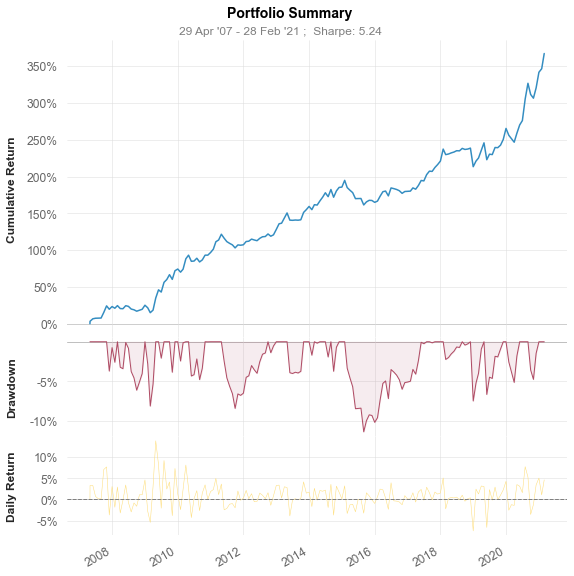

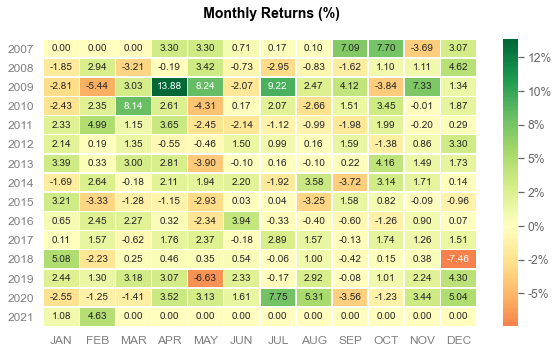

In [46]:
quantstats.reports.plots(DAAReturn['DAA'], mode='basic')